In [ ]:
%%HTML
<style>
.container {
    width:80% ! important;
}
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
.rendered_html { 
    font-size:1.0em; 
}
.rendered_html table{
    width: 80%;
    margin-left:auto; 
    margin-right:auto;
    padding: 20px;
    border: 0px solid black;    
    background-color: #ff;
}
.rendered_html td, .rendered_html th 
{
    vertical-align: top;
    text-align: left;
    font-size: 14px;
    font-face: sans-serif;
}
</style>

<center>
<h1> Analysis of Variable Stars using Periodograms and Autoencoders</h1>
<h2>Pablo Huijse H. (phuijse at inf dot uach dot cl)</h2>
<h3>Universidad Austral de Chile & Millennium Institute of Astrophysics</h3>
</center>

LIVE at https://github.com/phuijse/tutorial_periodic_stars

Thanks to
- The organizers
- The Millennium Institute of Astrophysics
- CONICYT FONDECYT 1170305 and PAI 79170017


# Variable stars
***

- Stars whose brightness change in time
- Different reasons behind this

### Pulsating variables
- Some variable stars pulsate radially
- They expand/heat and contract/cool regularly
- Examples: Cepheid and RR Lyrae

<center>
<a href="https://www.youtube.com/watch?v=sXJBrRmHPj8">
    <img src="https://media.giphy.com/media/QP4taxvfVmVEI/giphy.gif" width="400">
</a>
</center>

### Eclipsing Binaries

- System of two stars
- The rotational plane is aligned with us
- From our point of view we see brightness decrease with the mutual eclipses
<center>
<table>
    <tr><td>
        <a href="http://www.physast.uga.edu/~rls/astro1020/ch16/ovhd.html">
            <img src="img/intro-eb.gif" width="300">
        </a>
    </td>
    <td>
        <a href="https://en.wikipedia.org/wiki/File:Algol_AB_movie_imaged_with_the_CHARA_interferometer_-_labeled.gif">
            <img src="https://media.giphy.com/media/aYb0Ob2GHJ280/giphy.gif" width="300">
        </a>
    </td></tr>
</table>
</center>

# Scientific motivation
***

- Variable stars as distance tracers: Milky-way maps
<table>
    <tr><td>   
        <img src="img/period-luminosity-relation.gif" width="400">
    </td><td>
        <img src="img/intro-milky-way.jpg" width="400">
    </td></tr>
</table>


- Variable star analysis and classification: **Astrophysics**
<center>
<a href="http://www.atnf.csiro.au/outreach/education/senior/astrophysics/variable_types.html">
    <img src="img/variable-star-classification.gif" width="400">
</a>
</center>
- New methods to analyze astronomical data: **Signal processing** and **Data Science**
    - Room for interdisciplinary research
    - Astroinformatics and Astrostatistics


# Light curve
***

- Time series of a star's flux (brightness) on a given passband
- The "apparent" brightness is estimated through **Photometry**
- Variable stars are studied through their light curves

<table><tr><td>
    <img src="img/intro-vista.png" width="250">
</td><td>
    <img src="img/intro-sources.png" width="300">
</td></tr></table>

<center>
    <img src="img/intro-sources-time.png" width="600">
</center>

In [1]:
import gzip
import pickle
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib import rcParams, animation
rcParams.update({'font.size': 12})
rcParams.update({'axes.grid': True})

# Get some light curves to play
with gzip.open("data/lc_data.pgz", mode="r") as f:
    lc_data = pickle.load(f)

lc_periods = pickle.load(open("data/lc_periods.pkl", "rb"))

## Inspecting a light curve
***

In this case light curves are text files with three colums
- **Modified Julian Data (MJD):** Corresponds to time 
- **Magnitude:** Corresponds to apparent brightness (log scale)
- **Error:** Photometric error estimation of the magnitude

<IPython.core.display.Javascript object>


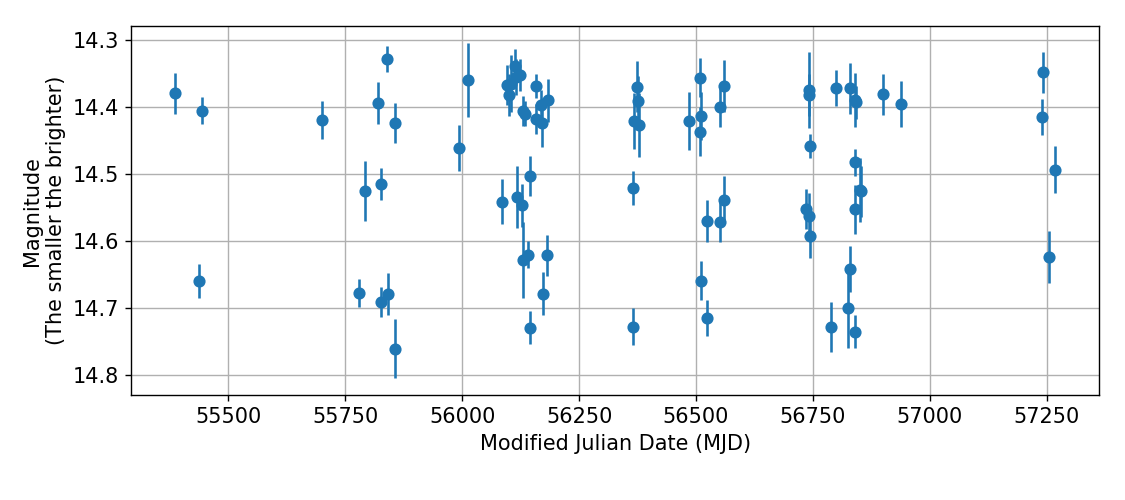

In [2]:
fig, ax = plt.subplots(figsize=(9, 4), tight_layout=True)
mjd, mag, err = lc_data[6].T
ax.errorbar(mjd, mag, err, fmt='o')
ax.invert_yaxis(); 
ax.set_xlabel('Modified Julian Date (MJD)\n ')
ax.set_ylabel('Magnitude\n(The smaller the brighter)');

- Irregular sampling, data gaps
- Heteroscedastic noise: Error variance change in time

This light curve is actually from a periodic variable star...

<IPython.core.display.Javascript object>


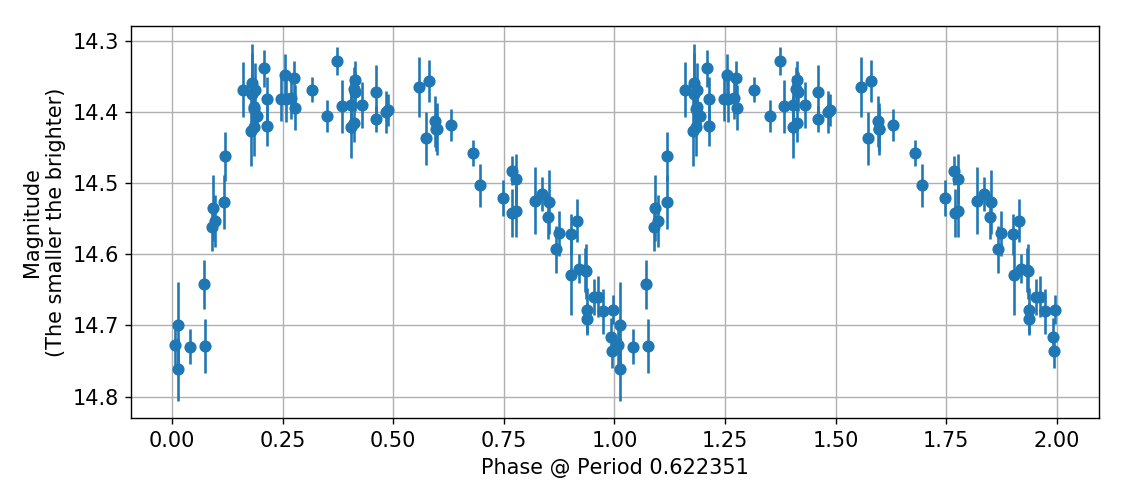

In [3]:
def fold(time, period):
    """
    returns phase = time/period - floor(time/period)
    """
    return np.mod(time, period)/period

idx = 6
mjd, mag, err = lc_data[idx].T
fig, ax = plt.subplots(figsize=(9, 4), tight_layout=True)
phi = fold(mjd, lc_periods[idx])
ax.errorbar(np.hstack((phi, phi+1)), 
            np.hstack((mag, mag)), 
            np.hstack((err, err)), fmt='o')
ax.invert_yaxis(); 
ax.set_ylabel('Magnitude\n(The smaller the brighter)');
ax.set_xlabel('Phase @ Period %0.6f' %(lc_periods[idx]));

## Folding the light curve
***
- Technique used by astronomers to visually inspect periodic variables
- You need a candidate period $P$ to perform the folding
- The time axis is divided in chucks of size $P$ and plotted on top each other

$$
\phi = \text{modulo}(\text{MJD}, P)/P
$$
- Then you plot the magnitude as a function of $\phi$ 
    - If $P$ is close to the true period:  Nice periodic shape
    - Otherwise: Noisy pattern



<IPython.core.display.Javascript object>


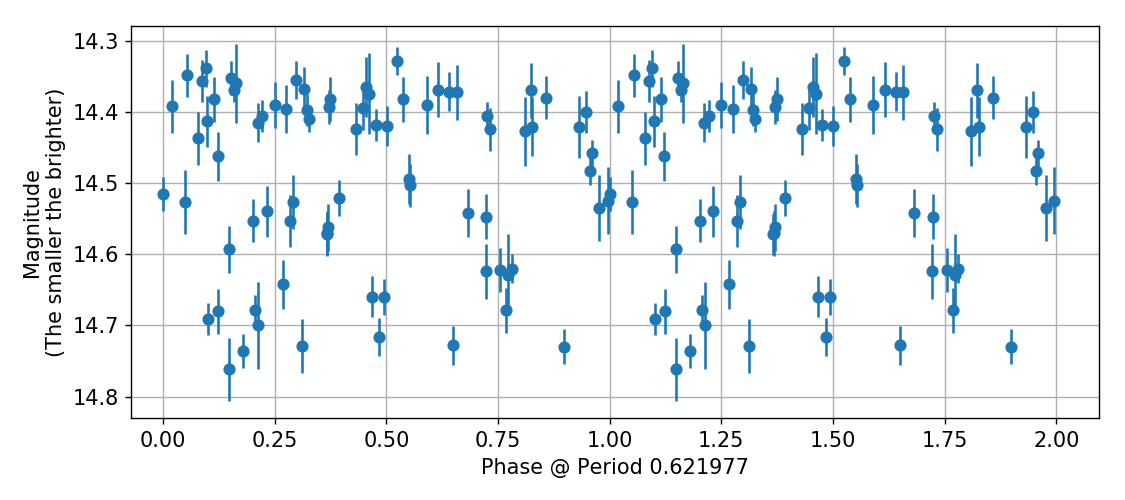

In [4]:
fig, ax = plt.subplots(figsize=(9, 4), tight_layout=True)
period_grid = np.linspace(lc_periods[6]-0.001, lc_periods[6]+0.001, num=100)
phi = fold(mjd, period_grid[0])
line, caps, errorbars = ax.errorbar(np.hstack((phi, phi+1)), 
                                    np.hstack((mag, mag)), 
                                    np.hstack((err, err)), fmt='o')
segs = errorbars[0].get_segments()
ax.invert_yaxis(); 
ax.set_ylabel('Magnitude\n(The smaller the brighter)');

def update(n):
    phi = fold(mjd, period_grid[n])
    for i in range(len(segs)//2):
        segs[i][:, 0] = phi[i]
        segs[i+len(phi)][:, 0] = phi[i]+1

    line.set_xdata(np.hstack((phi, phi+1)))
    errorbars[0].set_segments(segs)
    ax.set_xlabel('Phase @ Period %0.6f' %(period_grid[n]))

anim = animation.FuncAnimation(fig, update, frames=100, interval=100, repeat=False, blit=True)

## Periodograms
***
- We want to find the period (fundamental frequency) of the star
- This is generally done using the **periodogram**
- The periodogram is an estimator of the signal's **power as a function of frequency**
- It can be computed as the FFT of the autocorrelation

<IPython.core.display.Javascript object>


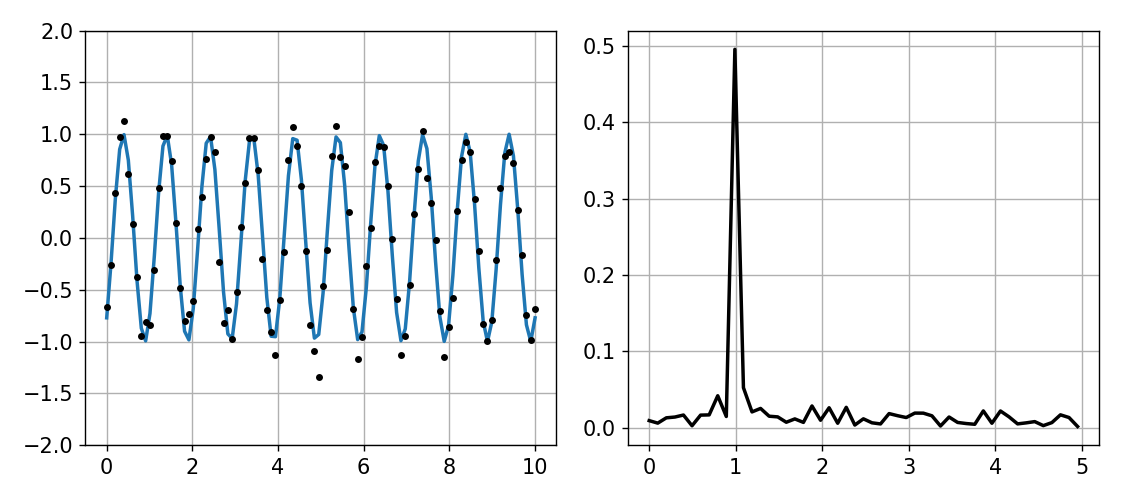

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), tight_layout=True)
time, dtime = np.linspace(0, 10, num=100, retstep=True)
freq = np.fft.rfftfreq(d=dtime, n=100)
noise = np.random.randn(len(time))
def draw(step):
    ax[0].cla(); ax[1].cla(); ax[0].set_ylim([-2, 2])
    s = np.sin(2*np.pi*time - 2.0*np.pi*step/50)
    ax[0].plot(time, s, lw=2); s+= noise*step/50; ax[0].plot(time, s, 'k.')
    ax[1].plot(freq, np.abs(np.fft.rfft(s)/len(time)), 'k-', lw=2)
anim = animation.FuncAnimation(fig, draw, frames=100, interval=100, repeat=False, blit=True)

But the FFT and correlation assumme regular time sampling

Estimating the period in irregularly sampled time series:
1. Best least squares fit of sine wave: Lomb-Scargle periodogram
1. Most "ordered" folded light curve: Conditional Entropy and **Mutual Information**
1. ....

In [ ]:
!pip install P4J --user

<IPython.core.display.Javascript object>


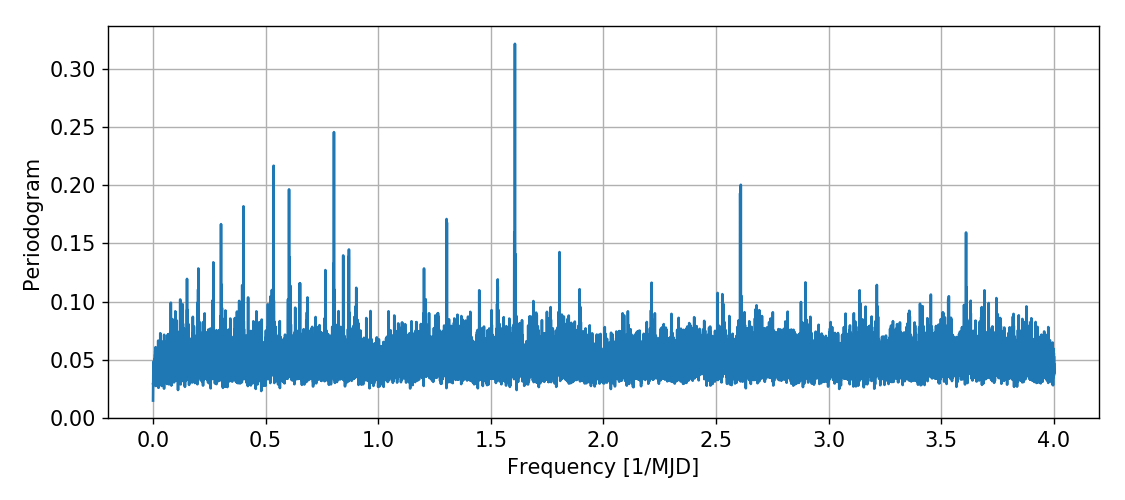

Best period: 0.622351 days


In [6]:
import P4J
my_per = P4J.periodogram(method='QMIEU') 
mjd, mag, err = lc_data[6].T
my_per.set_data(mjd, mag, err, h_KDE_P=0.2)
my_per.frequency_grid_evaluation(fmin=0.0, fmax=4.0, fresolution=1e-4)
my_per.finetune_best_frequencies(fresolution=1e-5, n_local_optima=10)
freq, per = my_per.get_periodogram()
fbest, pbest  = my_per.get_best_frequencies()

fig, ax = plt.subplots(figsize=(9, 4), tight_layout=True)
ax.plot(freq, per)
ax.set_xlabel('Frequency [1/MJD]')
ax.set_ylabel('Periodogram')
print("Best period: %f days" %(1.0/fbest[0]))

<IPython.core.display.Javascript object>


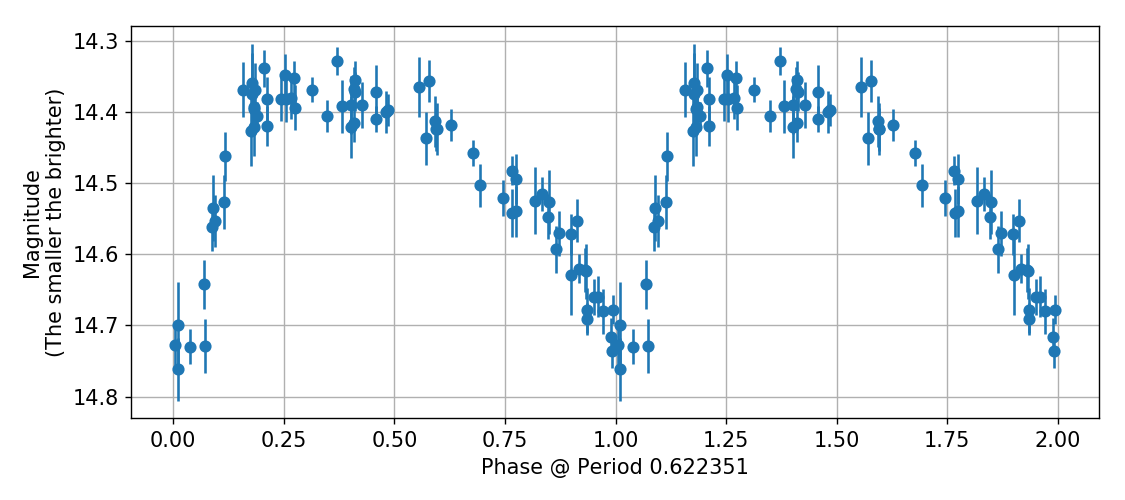

In [7]:
fig, ax = plt.subplots(figsize=(9, 4), tight_layout=True)
phi = fold(mjd, 1.0/fbest[0])
ax.errorbar(np.hstack((phi, phi+1)), 
            np.hstack((mag, mag)), 
            np.hstack((err, err)), fmt='o')
ax.invert_yaxis(); 
ax.set_ylabel('Magnitude\n(The smaller the brighter)');
ax.set_xlabel('Phase @ Period %0.6f' %(1.0/fbest[0]));

## Getting features from our periodic light curves

- We want to train a autoencoder neural network for light curves
- Given that we have the period we train on the folded light curve
- We normalize and interpolate the folded light curve using kernel regression


<IPython.core.display.Javascript object>


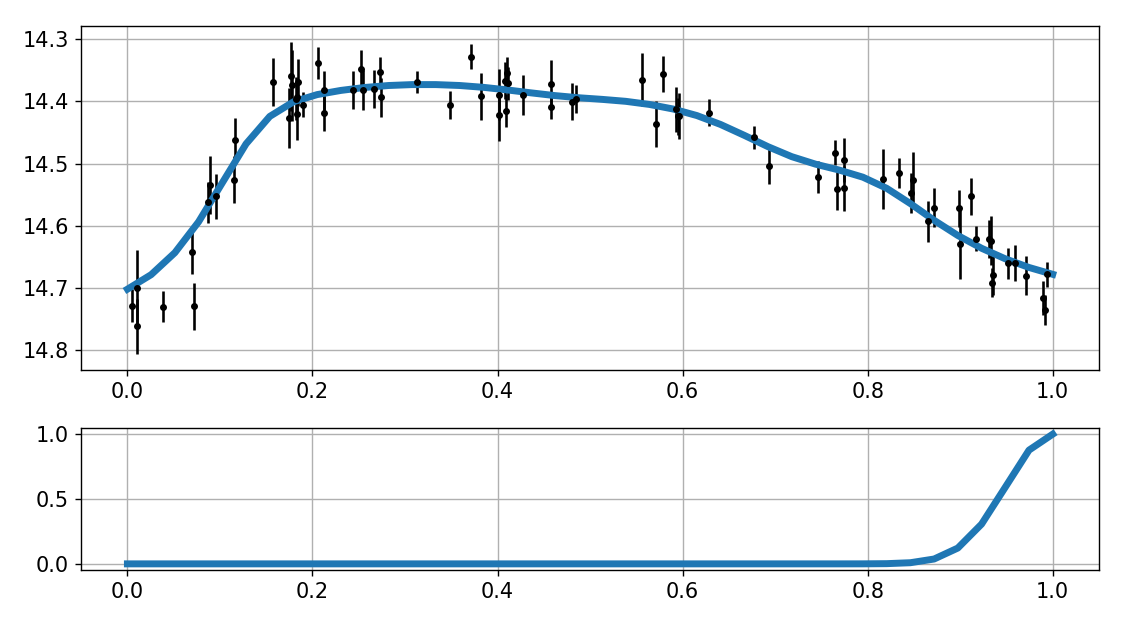

In [9]:
phi_interp = np.linspace(0, 1, num=40)
fig = plt.figure(figsize=(9, 5), tight_layout=True)
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2, fig=fig)
mjd, mag, err = lc_data[6].T
phi = fold(mjd, 1.0/fbest[0]); w = 1.0/err**2;
ax1.errorbar(phi, mag, err, fmt='.', c='k'); ax1.invert_yaxis();
l1 = ax1.plot(phi_interp, [np.amax(mag)]*len(phi_interp), lw=4)
ax2 = plt.subplot2grid((3,1), (2,0), rowspan=1, fig=fig)
l2 = ax2.plot(phi_interp, np.exp(-0.5*phi_interp**2/0.1**2), lw=4)
mag_interp = np.ones_like(phi_interp)*np.amax(mag)

def update(idx):
    gt = np.exp(-0.5*(phi_interp[idx]-phi)**2/0.05**2)
    mag_interp[idx] = np.sum(w*gt*mag)/np.sum(w*gt)
    l1[0].set_ydata(mag_interp)
    l2[0].set_ydata(np.exp(-0.5*(phi_interp-phi_interp[idx])**2/0.05**2))
anim = animation.FuncAnimation(fig, update, frames=40, interval=100, repeat=False, blit=True)

<IPython.core.display.Javascript object>


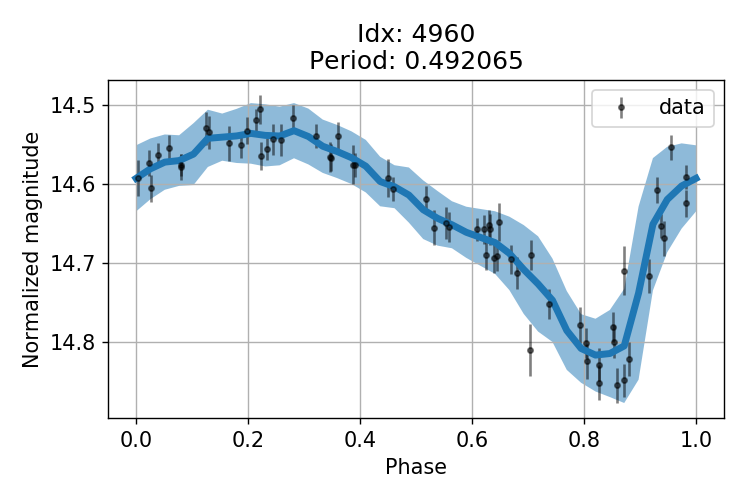

Button(description='Next', style=ButtonStyle())

In [10]:
from utils import featurize_lc, defeaturize_lc
from IPython.display import display
from ipywidgets import Button

features = np.zeros(shape=(len(lc_data), len(phi_interp)))
weights = np.zeros(shape=(len(lc_data), len(phi_interp)))
norm = np.zeros(shape=(len(lc_data), 3))
for i in range(len(lc_data)):
    features[i, :], weights[i, :], norm[i, :] = featurize_lc(lc_data[i], lc_periods[i], phi_interp)
    
next_button = Button(description="Next")
idx = 4950
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)

def plot_features(idx):
    ax.cla(); 
    ax.set_title("Idx: %d\nPeriod: %0.6f" %(idx, lc_periods[idx]))
    mag, err = defeaturize_lc(features[idx, :], weights[idx, :], norm[idx, :])
    ax.plot(phi_interp, mag, lw=4)
    ax.fill_between(phi_interp, (mag-err), (mag+err), alpha=0.5)
    ax.set_xlabel('Phase'); ax.set_ylabel('Normalized magnitude');
    mjd, mag, err = lc_data[idx][:, 0], lc_data[idx][:, 1], lc_data[idx][:, 2]
    phi = fold(mjd, lc_periods[idx])
    ax.errorbar(phi, mag, err, fmt='.', c='k', alpha=0.5, label='data'); 
    ax.invert_yaxis()
    plt.legend();

def on_nbutton_clicked(b):
    global idx
    idx += 1
    plot_features(idx)
                
next_button.on_click(on_nbutton_clicked)
plot_features(idx)
next_button

# Training a variational autoencoder

1. In this part we will train an [autoencoder](https://docs.google.com/presentation/d/1IJ2n8X4w8pvzNLmpJB-ms6-GDHWthfsJTFuyUqHfXg8/edit?usp=sharing) to visualize the feature space 
- We will use [PyTorch](https://pytorch.org/) to create and train the model
- We have light curves with unknown label and 50 light curves labeled as **RR Lyrae**
- Can we find unlabeled light curves that belong to the RR Lyrae class?

In [131]:
import torch 
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

class simple_MLP(torch.nn.Module):
    
    def __init__(self, n_input=2, n_hidden=2, n_output=1):
        super(simple_MLP, self).__init__()
        # Encoder layers
        self.hidden = torch.nn.Linear(n_input, n_hidden)
        self.output = torch.nn.Linear(n_hidden, n_output)
    
    def forward(self, x):
        z = F.relu(self.hidden(x))
        y = self.output(z)
        return y

hello_world_model = simple_MLP(n_hidden=6)
print(hello_world_model)
optimizer = torch.optim.Adam(hello_world_model.parameters(), lr=1e-1)

data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
label = np.array([0, 1, 1, 0])
xor_dataset = TensorDataset(torch.from_numpy(data.astype('float32')),
                            torch.from_numpy(label.astype('float32')))

xor_loader = DataLoader(dataset=xor_dataset, batch_size=1, shuffle=True)

for epoch in range(100):
    for bdata, labels in xor_loader:
        optimizer.zero_grad()
        predictions = hello_world_model.forward(bdata)
        loss = F.binary_cross_entropy_with_logits(predictions, labels.unsqueeze(1))        
        loss.backward()
        optimizer.step()

torch.sigmoid(hello_world_model(xor_dataset.tensors[0]))

simple_MLP(
  (hidden): Linear(in_features=2, out_features=6, bias=True)
  (output): Linear(in_features=6, out_features=1, bias=True)
)


tensor([[0.0293],
        [0.9994],
        [0.9988],
        [0.0004]], grad_fn=<SigmoidBackward>)

In [16]:
def logsumexp(inputs, dim=None, keepdim=True):    
    # From: https://github.com/YosefLab/scVI/issues/13
    return (inputs - F.log_softmax(inputs, dim=dim)).sum(dim, keepdim=keepdim)

class VAE(torch.nn.Module):
    def __init__(self, n_input=40, n_hidden=[10, 10], n_latent=2, importance_sampling=False):
        super(VAE, self).__init__()
        self.importance = importance_sampling
        # Encoder layers
        self.enc_hidden1 = torch.nn.Linear(n_input, n_hidden[0])
        self.enc_hidden2 = torch.nn.Linear(n_hidden[0], n_hidden[1])
        #self.enc_hidden = torch.nn.Conv1d(in_channels=1, kernel_size=10, out_channels=n_hidden)
        self.enc_mu = torch.nn.Linear(n_hidden[1], n_latent)
        self.enc_logvar = torch.nn.Linear(n_hidden[1], n_latent)
        # decoder layers
        self.dec_hidden2 = torch.nn.Linear(n_latent, n_hidden[1]) 
        self.dec_hidden1 = torch.nn.Linear(n_hidden[1], n_hidden[0]) 
        self.dec_mu = torch.nn.Linear(n_hidden[0], n_input)
        self.dec_logvar = torch.nn.Linear(n_hidden[0], 1)

        
    def encode(self, x):
        h = F.relu(self.enc_hidden1(x))
        h = F.relu(self.enc_hidden2(h))
        #h = F.relu(self.enc_hidden(x.unsqueeze(1)))
        #h = F.adaptive_avg_pool1d(h, output_size=1).view(-1, 20)
        return self.enc_mu(h), self.enc_logvar(h)

    def sample(self, mu, logvar, k=1):
        batch_size, n_latent = logvar.shape
        std = (0.5*logvar).exp()
        eps = torch.randn(batch_size, k, n_latent, device=std.device, requires_grad=False)
        return eps.mul(std.unsqueeze(1)).add(mu.unsqueeze(1))

    def decode(self, z):
        h = F.relu(self.dec_hidden2(z))
        h = F.relu(self.dec_hidden1(h))
        hatx, hatlogvar = self.dec_mu(h), self.dec_logvar(h)
        return hatx, hatlogvar        

    def forward(self, x, k=1):
        enc_mu, enc_logvar = self.encode(x)
        z = self.sample(enc_mu, enc_logvar, k)
        dec_mu, dec_logvar = self.decode(z)
        return dec_mu, enc_mu, enc_logvar, dec_logvar, z
    
    def ELBO(self, x, w, mc_samples=1):  
        dec_mu, enc_mu, enc_logvar, dec_logvar, z = self.forward(x, mc_samples)
        logpxz = -0.5*(2.*torch.log(w.unsqueeze(1) + (dec_logvar/2).exp()) \
                       + (x.unsqueeze(1) - dec_mu).pow(2)/(dec_logvar.exp() + w.pow(2).unsqueeze(1))).sum(dim=-1)    
        #logpxz = -0.5*(dec_logvar + (x.unsqueeze(1) - dec_mu).pow(2)/dec_logvar.exp()).sum(dim=-1)    
        
        if self.importance: # Importance-Weighted autoencoder (IWAE)
            logqzxpz = 0.5 * (z.pow(2) - z.sub(enc_mu.unsqueeze(1)).pow(2)/enc_logvar.unsqueeze(1).exp() - enc_logvar.unsqueeze(1)).sum(dim=-1)
        else:  # Variational autoencoder
            logqzxpz = -0.5 * (1.0 + enc_logvar - enc_mu.pow(2) - enc_logvar.exp()).sum(dim=-1).unsqueeze_(1)
        ELBO = torch.sum(logsumexp(logqzxpz - logpxz, dim=1) + np.log(mc_samples))
        return ELBO, logpxz.sum()/mc_samples, logqzxpz.sum()/logqzxpz.shape[1]
 

In [ ]:
!pip install tqdm

VAE(
  (enc_hidden1): Linear(in_features=40, out_features=20, bias=True)
  (enc_hidden2): Linear(in_features=20, out_features=10, bias=True)
  (enc_mu): Linear(in_features=10, out_features=2, bias=True)
  (enc_logvar): Linear(in_features=10, out_features=2, bias=True)
  (dec_hidden2): Linear(in_features=2, out_features=10, bias=True)
  (dec_hidden1): Linear(in_features=10, out_features=20, bias=True)
  (dec_mu): Linear(in_features=20, out_features=40, bias=True)
  (dec_logvar): Linear(in_features=20, out_features=1, bias=True)
)
Number of trainable parameters: 2185


<IPython.core.display.Javascript object>


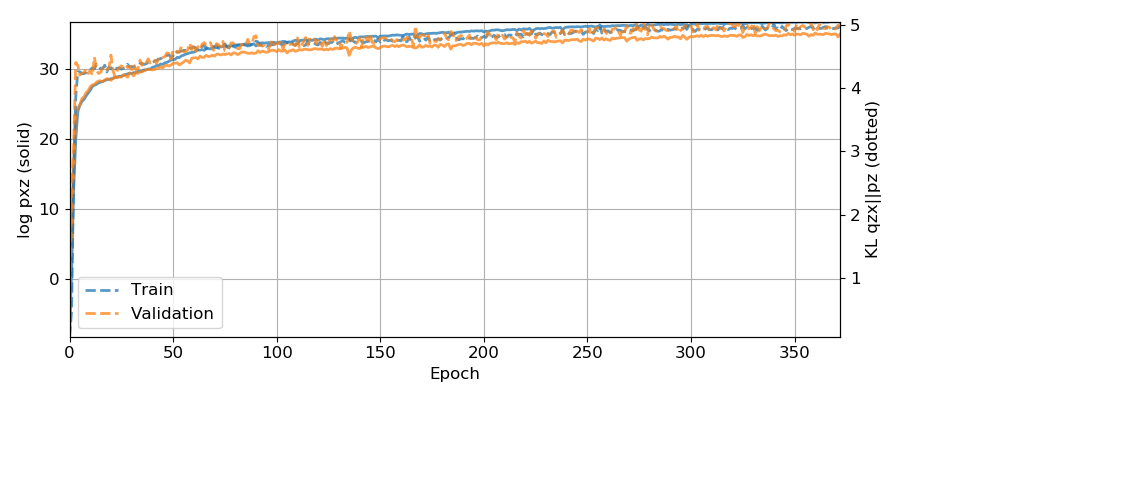

KeyboardInterrupt: 

In [87]:
from utils import live_metric_plotter
from tqdm import tqdm_notebook

# Create light curve dataset from numpy arrays
lc_dataset = TensorDataset(torch.from_numpy(features.astype('float32')), 
                           torch.from_numpy(weights.astype('float32')),
                           torch.from_numpy(lc_periods.astype('float32')))

batch_size_, nepochs, mc_samples = 32, 100, 32
torch.manual_seed(0);  np.random.seed(0) # reproducible results, comment this for real world

# Generate data loaders
P = np.random.permutation(5000)
train_loader = DataLoader(dataset=lc_dataset, batch_size=batch_size_, 
                          sampler=torch.utils.data.SubsetRandomSampler(P[:4000]))
valid_loader = DataLoader(dataset=lc_dataset, batch_size=batch_size_, 
                          sampler=torch.utils.data.SubsetRandomSampler(P[4000:]))

# instantiate model
model = VAE(n_input=40, n_hidden=[20, 10], n_latent=2, importance_sampling=True)
print(model)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("Number of trainable parameters: %d" %(sum([np.prod(p.size()) for p in model_parameters])))

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
plotter = live_metric_plotter(figsize=(9, 4))
metrics = np.zeros(shape=(nepochs, 2, 2))

# Train
for epoch in tqdm_notebook(range(nepochs)):
    for feature, weight, period in train_loader:
        optimizer.zero_grad()        
        loss, rec_loss, reg_loss = model.ELBO(feature, weight, mc_samples)        
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)        
        optimizer.step()
        metrics[epoch, 0, 0] += rec_loss.detach().numpy()/len(train_loader.sampler)
        metrics[epoch, 0, 1] += reg_loss.detach().numpy()/len(train_loader.sampler)
    # Test
    for feature, weight, period in valid_loader:
        loss, rec_loss, reg_loss = model.ELBO(feature, weight, mc_samples)
        metrics[epoch, 1, 0] += rec_loss.detach().numpy()/len(valid_loader.sampler)
        metrics[epoch, 1, 1] += reg_loss.detach().numpy()/len(valid_loader.sampler)
    
    if epoch > 0:
        plotter.update(epoch, metrics)

In [ ]:
!pip install bokeh

In [88]:
test_dec_mu, test_enc_mu, test_enc_logvar, test_dec_logvar, test_z = model.forward(lc_dataset.tensors[0], k=10)
test_enc_mu, test_enc_sigma = test_enc_mu.detach().numpy(), (test_enc_logvar.detach()*0.5).exp().numpy()
test_dec_mu = test_dec_mu.detach().numpy()

from bokeh import __version__
print(__version__)
from bokeh.io import output_notebook, show, push_notebook
from bokeh.layouts import row, column 
from bokeh.models import Whisker, Band, ColumnDataSource, HoverTool, CustomJS, Range1d
from bokeh.plotting import figure
output_notebook()

1.0.2


Loading BokehJS ...

In [89]:
TOOLS = "pan, wheel_zoom, reset"
hover = HoverTool(tooltips=[("index", "$index")])    
main_plot = figure(tools=[hover, TOOLS], plot_width=600, plot_height=600, 
                   min_border=10, min_border_left=0,
                   toolbar_location="above", title="Latent space")

lc_plots, lc_sources = [], []
p = figure(tools=TOOLS, plot_width=350, plot_height=250, toolbar_location="above", title='Data')
source = ColumnDataSource(data={'x': [0], 'y': [0], 'y+dy': [0.1], 'y-dy': [-0.1]}) 
p.circle('x', 'y', size=5, line_color="black", fill_color="black", source=source)
p.add_layout(Whisker(source=source, base="x", upper="y+dy", lower="y-dy"))
lc_plots.append(p)
lc_sources.append(source)

p = figure(tools=TOOLS, plot_width=350, plot_height=250, toolbar_location="above", title='Features')
source = ColumnDataSource(data={'x': [0], 'y_rec': [0], 
                                'y_feat': [0], 'y_rec_lower': [-1], 'y_rec_upper': [1]})

p.line('x', 'y_feat', line_width=4, color='blue', source=source)
p.line('x', 'y_rec', line_width=4, color='red', source=source)
band = Band(base='x', lower='y_rec_lower', upper='y_rec_upper', source=source, 
            level='underlay', fill_alpha=0.5, fill_color='red', line_width=None)
p.add_layout(band)
lc_plots.append(p)
lc_sources.append(source)

labels = np.zeros(shape=(5000,)); labels[4950:] = 1
colors = ['red' if label else 'blue' for label in labels]
sc = main_plot.scatter(test_enc_mu[:, 0], test_enc_mu[:, 1], 
                       size=5, alpha=0.5, fill_color=colors, line_color=None)


callback = CustomJS(args={'segment': sc.data_source}, code=""" 
if (IPython.notebook.kernel !== undefined && cb_data.index.indices !== undefined) {
    var kernel = IPython.notebook.kernel;
    cmd = "update_plots(" + cb_data.index.indices[0] + ")";
    kernel.execute(cmd, {}, {})}; 
""")

main_plot.hover.callback=callback

t = show(row(main_plot, 
             column(lc_plots[0], lc_plots[1])), notebook_handle=True)

def update_plots(idx):
    #print(idx)
    mjd, mag, err = lc_data[idx].T
    phi = fold(mjd, lc_dataset.tensors[2][idx]).numpy()
    lc_sources[0].data={'x': phi, 'y': -mag, 'y+dy': -mag+err, 'y-dy': -mag-err} 
    mu_dec = np.mean(test_dec_mu[idx], axis=0)
    s_dec = 2*np.std(test_dec_mu[idx], axis=0)
    lc_sources[1].data={'x': phi_interp, 'y_feat': -lc_dataset[idx][0].numpy(), 
                        'y_rec': -mu_dec, 'y_rec_lower':-mu_dec+s_dec, 'y_rec_upper':-mu_dec-s_dec} 
    
    
    push_notebook(handle=t)

<IPython.core.display.Javascript object>


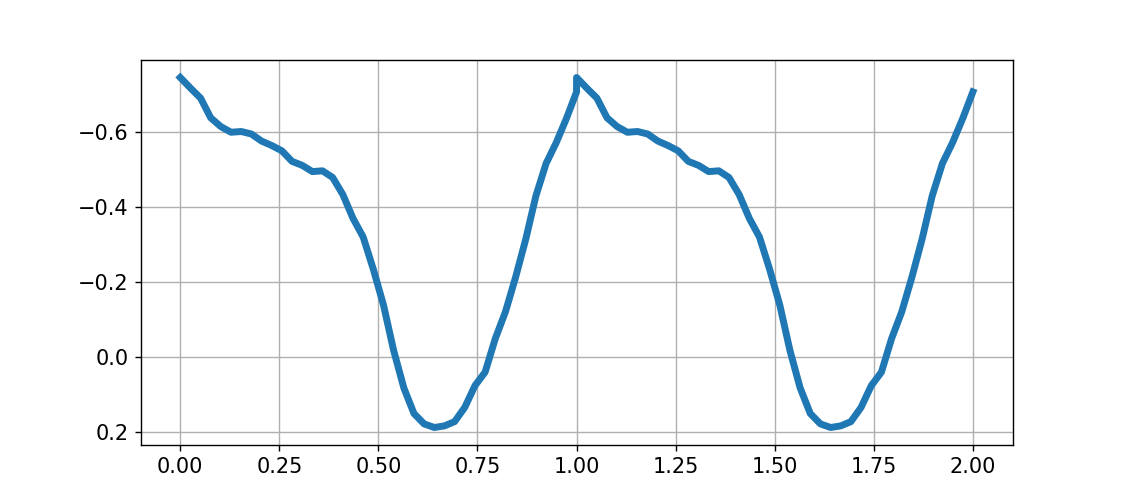

In [85]:
z = model.sample(torch.tensor([[0., -1.]]), torch.tensor([[-3., -3.]]), k=2)
hatmu, hats = model.decode(z)
hatmu, hats = hatmu.detach().numpy()[0][0], (hats/2.).exp().detach().numpy()[0][0]
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(np.concatenate((phi_interp, phi_interp+1)), 
        np.concatenate((hatmu, hatmu)), lw=4)
ax.invert_yaxis();

<IPython.core.display.Javascript object>


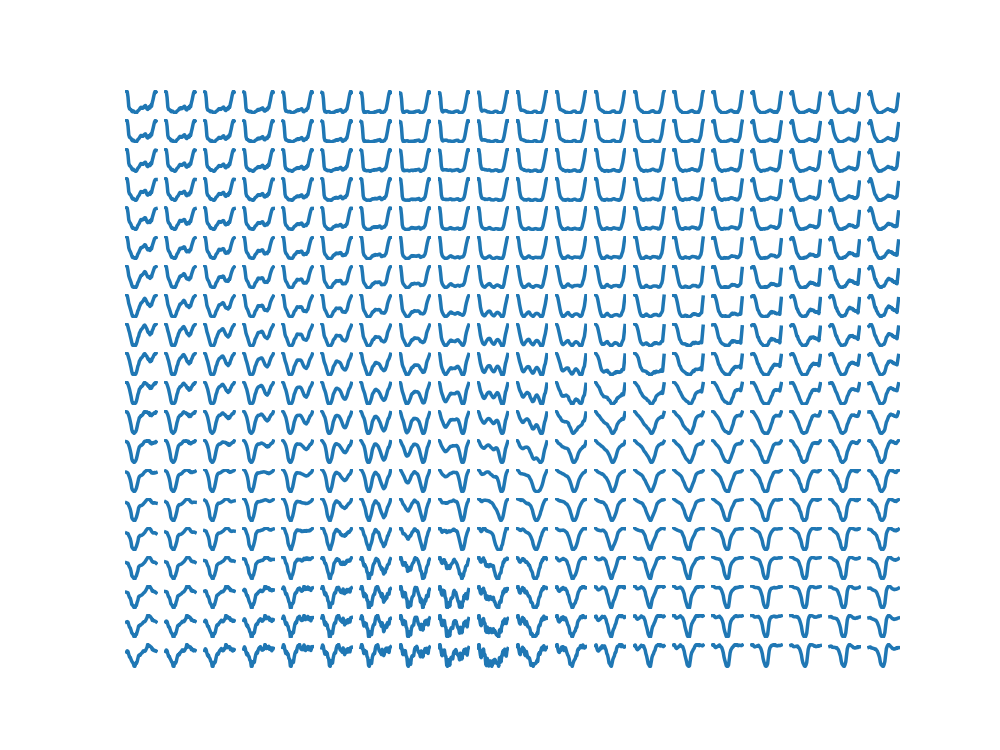

In [86]:
fig, ax = plt.subplots(20, 20, figsize=(8, 6), tight_layout=True)
for i in range(20):
    for j in range(20):
        hatmu, hats = model.decode(torch.tensor([-3. + 6.*j/20, 3. - 6.*i/20]))
        ax[i, j].plot(phi_interp, hatmu.detach().numpy(), lw=2)
        ax[i, j].invert_yaxis(); ax[i, j].axis('off')
                           

In [ ]:
"""
The figure shows the digits in latent space as a dot (mean of the variational posterior) with 
errorbars (standard deviation of the variational posterior). Each point is a distribution!
"""
fig = plt.figure(figsize=(10, 5), dpi=80)
ax_main = plt.subplot2grid((2, 3), (0, 0), colspan=2, rowspan=2)
ax_ori = plt.subplot2grid((2, 3), (0, 2))
ax_rec = plt.subplot2grid((2, 3), (1, 2))
a, b, c = ax_main.errorbar(x=test_enc_mu[:, 0], y=test_enc_mu[:, 1], 
                           xerr=test_enc_sigma[:, 0], yerr=test_enc_sigma[:, 1], 
                           fmt='none', alpha=0.2, zorder=-1)
labels = np.zeros(shape=(5000,)); labels[4950:] = 1

sc = ax_main.scatter(test_enc_mu[:, 0], test_enc_mu[:, 1], s=2, alpha=0.2, 
                     c=labels, cmap=plt.cm.RdBu_r)
clb = plt.colorbar(sc, ax=ax_main)
for i in range(2):
    c[i].set_color(clb.to_rgba(labels))
    
    
c_lim, r_lim = ax_main.get_xlim(), ax_main.get_ylim()
plt.tight_layout()
phi_interp = np.linspace(0, 1, num=40)
def onclick(event):
    z_closest = [event.xdata, event.ydata]
    print(z_closest)
    idx = np.argmin(np.sum((test_enc_mu[:, :2] - z_closest)**2, axis=1))
    ax_ori.cla(); ax_ori.set_title("Idx:%d, Label:%d" %(idx, labels[idx]))
    mjd, mag, err = lc_data[idx].T
    phi = fold(mjd, lc_dataset.tensors[2][idx])
    ax_ori.errorbar(phi, mag, err, c='k', fmt='.')
    mag, err = defeaturize_lc(lc_dataset.tensors[0][idx].numpy(), 
                              lc_dataset.tensors[1][idx].numpy(), norm[idx])
    ax_ori.plot(phi_interp, mag, lw=2)
    ax_ori.fill_between(phi_interp, mag - err, mag + err, alpha=0.5)
    ax_ori.invert_yaxis(); 
    ax_rec.cla(); ax_rec.invert_yaxis(); #ax_rec.set_ylim([2.5, -1.5]); 
    mag, err = lc_dataset.tensors[0][idx].numpy(), lc_dataset.tensors[1][idx].numpy()
    ax_rec.plot(phi_interp, mag, lw=2)
    ax_rec.fill_between(phi_interp, mag - err, mag + err, alpha=0.5)
    mu_dec = np.mean(test_dec_mu[idx], axis=0)
    s_dec = np.std(test_dec_mu[idx], axis=0)
    ax_rec.plot(phi_interp, mu_dec, c='r', lw=2)
    ax_rec.fill_between(phi_interp, mu_dec-2*s_dec, mu_dec+2*s_dec, facecolor='r', alpha=0.5)
    
cid = fig.canvas.mpl_connect('button_press_event', onclick);